# Taller 2




# Entendimiento y preparación de los Datos

In [1]:
!pip install tensorflow
!pip install imbalanced-learn
!pip install matplotlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from pandas import merge
from PIL import Image

In [2]:
# Cargamos el csv classes para poder añadir las categorías a cada df y hacer el análisis con los nombres de los productos.
classes = pd.read_csv('dataset\classes.csv')

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13868\759888631.py:2: SyntaxWarning: invalid escape sequence '\c'
  classes = pd.read_csv('dataset\classes.csv')


In [3]:
classes.head(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...


In [4]:
# Creamos diccionario de las categorías.
diccionario = dict(zip(classes['Coarse Class ID (int)'], classes['Coarse Class Name (str)']))
print(diccionario)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Kiwi', 4: 'Lemon', 5: 'Lime', 6: 'Mango', 7: 'Melon', 8: 'Nectarine', 9: 'Orange', 10: 'Papaya', 11: 'Passion-Fruit', 12: 'Peach', 13: 'Pear', 14: 'Pineapple', 15: 'Plum', 16: 'Pomegranate', 17: 'Red-Grapefruit', 18: 'Satsumas', 19: 'Juice', 20: 'Milk', 21: 'Oatghurt', 22: 'Oat-Milk', 23: 'Sour-Cream', 24: 'Sour-Milk', 25: 'Soyghurt', 26: 'Soy-Milk', 27: 'Yoghurt', 28: 'Asparagus', 29: 'Aubergine', 30: 'Cabbage', 31: 'Carrots', 32: 'Cucumber', 33: 'Garlic', 34: 'Ginger', 35: 'Leek', 36: 'Mushroom', 37: 'Onion', 38: 'Pepper', 39: 'Potato', 40: 'Red-Beet', 41: 'Tomato', 42: 'Zucchini'}


In [ ]:

# Rura a la carpeta
base_dir = r'C:\Users\Usuario\Desktop\Universidad Maestría\Ciencia de datos\image-classification-tutorial-master\GroceryStoreDataset-master\dataset'

In [6]:
# Crear DataFrames a partir de los archivos .txt
def create_dataframe(file_path, base_dir):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            image_path, fine_label, coarse_label = line.strip().split()
            full_path = os.path.join(base_dir, image_path)
            data.append([full_path, fine_label, coarse_label])
    return pd.DataFrame(data, columns=['image_path', 'class_id', 'coarse_class_id'])

In [7]:
# Crear DataFrames para entrenamiento, validación y prueba
train_df = create_dataframe(os.path.join(base_dir, 'train.txt'), base_dir)
valid_df = create_dataframe(os.path.join(base_dir, 'val.txt'), base_dir)
test_df = create_dataframe(os.path.join(base_dir, 'test.txt'), base_dir)

In [8]:
train_df.shape

(2640, 3)

In [9]:
test_df.shape

(2485, 3)

In [10]:
valid_df.shape

(296, 3)

In [11]:
train_df.dtypes

image_path         object
class_id           object
coarse_class_id    object
dtype: object

In [12]:
# Para poder añadir la columna con los nombres, usando el coarse_class_id, se pasa a entero, también se hace con class_id.
for datos in [train_df, valid_df, test_df]:
    datos['class_id'] = datos['class_id'].str.replace(',', '').astype(int)
    datos['coarse_class_id'] = datos['coarse_class_id'].str.replace(',', '').astype(int)

In [13]:
# Se añade a cada df la columna con los nombres de las categorías.
for datos in [train_df, valid_df, test_df]:
    datos['coarse_class_name'] = datos['coarse_class_id'].map(diccionario)

In [14]:
train_df.dtypes

image_path           object
class_id              int32
coarse_class_id       int32
coarse_class_name    object
dtype: object

In [15]:
train_df.head(5)

,image_path,class_id,coarse_class_id,coarse_class_name
0,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
1,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
2,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
3,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
4,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple


  En cuanto al entendimiento de los datos, se tienen 3 dataframes (uno de grupo de entrenamiento, uno de prueba y uno de validación), cada uno de ellos tiene una carpeta respectiva en la cuál se tienen carpetas con las clases de productos, y dentro de estas, las subclases de productos con sus respectivas imágenes y finalmente se tiene un dataframe con los ID de categoría y subcategorías, sus nombres y las rutas a las imágenes. Estas imágenes son tomadas con un celular inteligente y tienen dimensiones 198x198 píxeles.
  
  Para el modelo que se presentará a continuación, se tomarán en cuenta las clases de los productos. Por lo que a continuación se presenta su distribución para cada uno de los data frames.


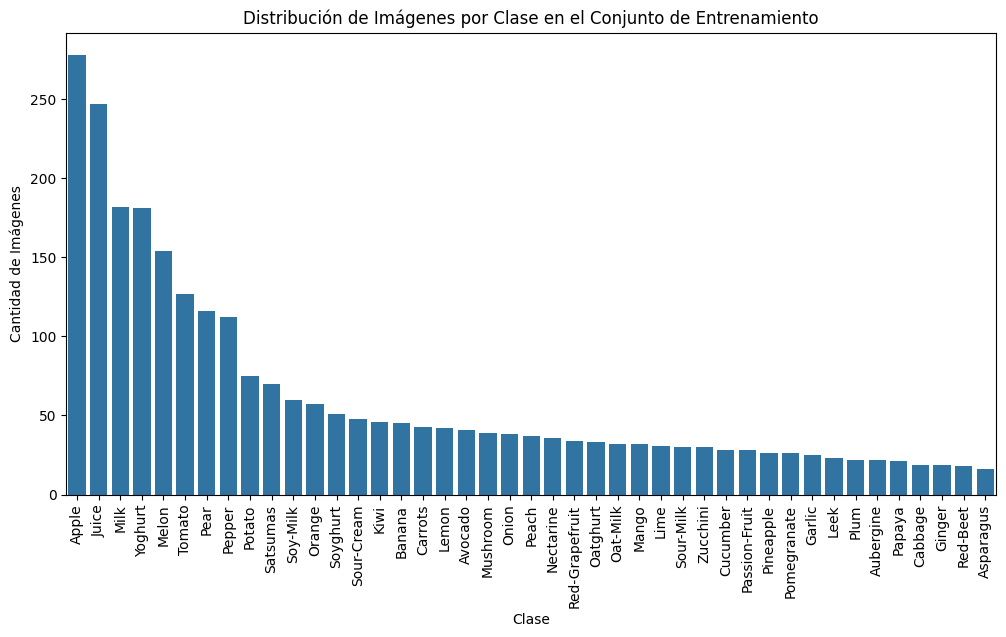

In [16]:
# Contar el número de imágenes por clase usando `coarse_class_id`
class_counts = train_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

En la gráfica anterior, se puede observar la distribución de las categorías en el grupo de entrenamiento. De las 5 primeras categorías, se tiene que con una diferencia significativa, la categoría con mayor cantidad de datos es la de manzanas (aproximadamente 280), seguida por la de jugos (aproximadamente 245), con una diferencia aproximada de 70 sigue la leche que tiene alrededor de la misma cantidad que yogurt.

In [17]:
valid_df.head(5)

,image_path,class_id,coarse_class_id,coarse_class_name
0,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
1,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
2,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
3,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
4,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple


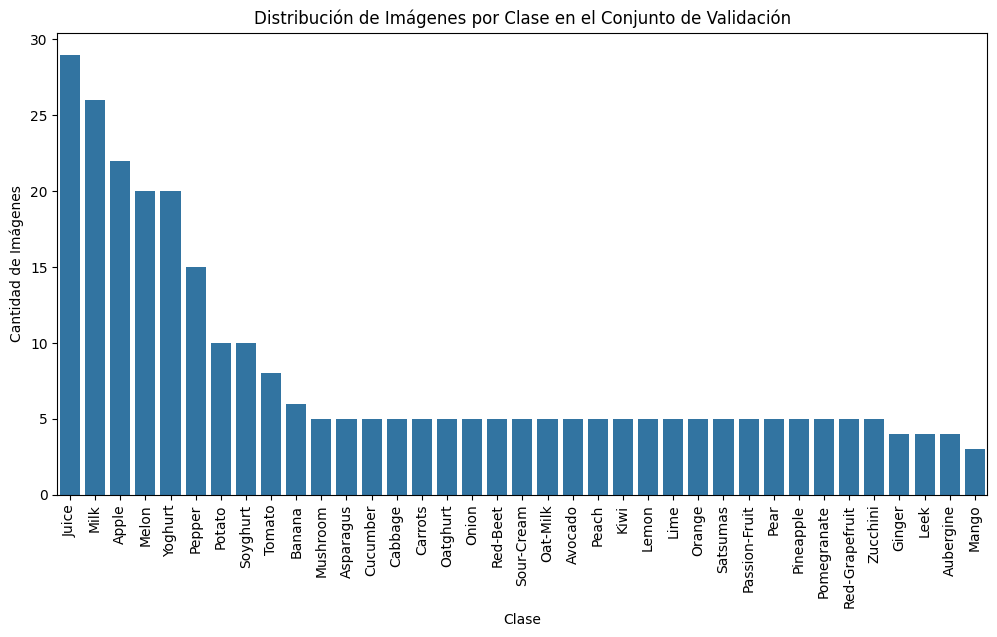

In [18]:
# Contar el número de imágenes por clase usando `coarse_class_id`
class_counts = valid_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Validación")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

En la gráfica anterior, se puede ver la distribución para el grupo de validación, se tiene que en las 5 primeras categorías, se encuentra el jugo (29), seguido de la leche (26), las manzanas (22), los melones (20) y el yogurt (20).

In [19]:
test_df.head(5)

,image_path,class_id,coarse_class_id,coarse_class_name
0,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
1,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
2,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
3,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple
4,C:\Users\Usuario\Desktop\Universidad Maestría\...,0,0,Apple


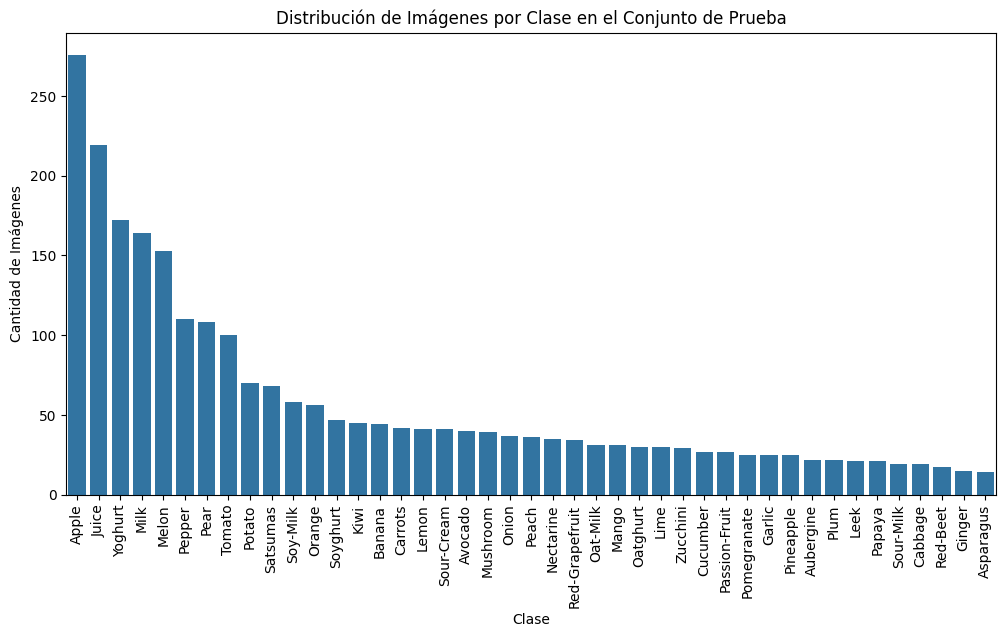

In [20]:
# Contar el número de imágenes por clase usando `coarse_class_id`
class_counts = test_df['coarse_class_name'].value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Distribución de Imágenes por Clase en el Conjunto de Prueba")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=90)
plt.show()

Finalmente, se presenta la grádica para el grupo de prueba. Se tiene que en las 5 primeras categorías se encuentran las manzanas en primer lugar (aproximadamente con 275), seguido del jugo (aproximadamente 220), el yogurt (aproximadamente 170), la leche (aproximadamente 160) y los melones (aproximadamente 150).

In [21]:
# Eliminar caracteres no deseados al final de las rutas
train_df['image_path'] = train_df['image_path'].str.strip().str.rstrip(',')
valid_df['image_path'] = valid_df['image_path'].str.strip().str.rstrip(',')
test_df['image_path'] = test_df['image_path'].str.strip().str.rstrip(',')

# Verificar si las imágenes se pueden cargar usando PIL
def check_images(dataframe):
    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        try:
            # Intentar abrir la imagen con PIL
            img = Image.open(image_path)
            img.verify()  # Verifica que la imagen no esté corrupta
        except (IOError, FileNotFoundError) as e:
            print(f"No se pudo leer la imagen en: {image_path}")
            print(f"Error: {e}")

# Aplicar la verificación a los DataFrames de entrenamiento, validación y prueba
print("Verificación imágenes de entrenamiento ok")
check_images(train_df)
print("Verificación imágenes de validación ok")
check_images(valid_df)
print("Verificación imágenes de prueba ok")
check_images(test_df)

Verificación imágenes de entrenamiento ok
Verificación imágenes de validación ok
Verificación imágenes de prueba ok


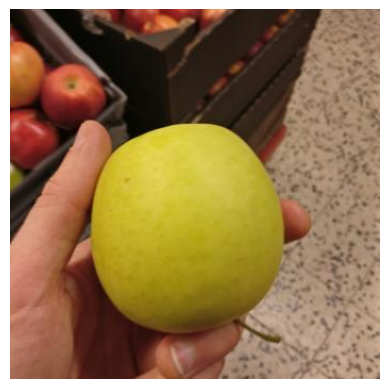

In [22]:
# Se realizan algunas impresiones de forma aleatoria para entendimiento de las imágenes.
img_path = train_df['image_path'][0]  
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off') 
plt.show()

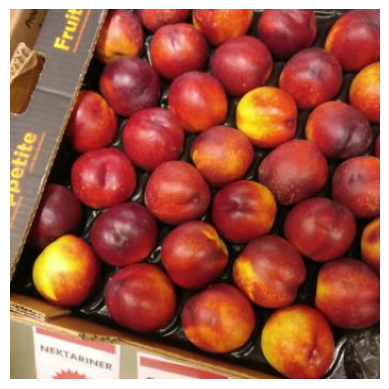

In [23]:
img_path = train_df['image_path'][690]  
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  
plt.show()

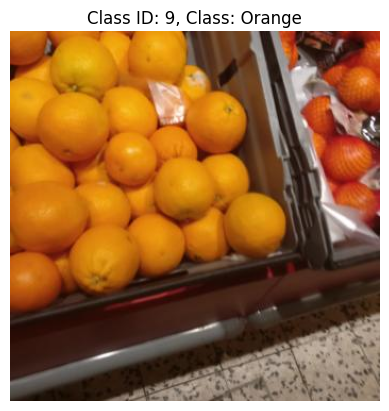

In [24]:
# Ahora se realiza la impresión de las imágenes con su Class ID y Class name.
def mostrar_imagen_con_etiqueta(train_df, idx):
    img_path = train_df.iloc[idx]['image_path']
    coarse_class_id = train_df.iloc[idx]['coarse_class_id']
    coarse_class_name = train_df.iloc[idx]['coarse_class_name']
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Class ID: {coarse_class_id}, Class: {coarse_class_name}")
    plt.axis('off')
    plt.show()

# Mostrar una imagen con su etiqueta
mostrar_imagen_con_etiqueta(train_df, 716)

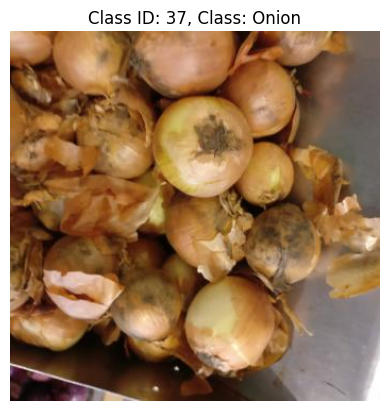

In [25]:
mostrar_imagen_con_etiqueta(train_df, 2260)

In [26]:
# Se verifica si hay rutas de imagen que no existen
missing_images_train = train_df[train_df['image_path'].apply(lambda x: not os.path.exists(x))]
print(missing_images_train)

missing_images_valid = valid_df[valid_df['image_path'].apply(lambda x: not os.path.exists(x))]
print(missing_images_valid)

missing_images_test = test_df[test_df['image_path'].apply(lambda x: not os.path.exists(x))]
print(missing_images_test)

Empty DataFrame
Columns: [image_path, class_id, coarse_class_id, coarse_class_name]
Index: []
Empty DataFrame
Columns: [image_path, class_id, coarse_class_id, coarse_class_name]
Index: []
Empty DataFrame
Columns: [image_path, class_id, coarse_class_id, coarse_class_name]
Index: []


In [27]:
# Función para cargar y procesar una imagen
def load_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)  # Redimensionar la imagen
    img_array = np.array(img)  # Convertir la imagen a un array numpy
    img_array = img_array / 255.0  # Normalizar los valores entre 0 y 1
    return img_array

In [28]:
# Función para cargar una imagen, redimensionarla y convertirla a un array numpy
def load_images_from_paths(df, target_size=(64, 64)):
    images = []
    for image_path in df['image_path']:
        img_array = load_image(image_path, target_size)
        images.append(img_array)
    return np.array(images)

# Modelo Random Forest

In [29]:
# Se realiza la asignación de las variables, X con los arreglos de las imágenes y Y con el ID de las clases.
X_train = load_images_from_paths(train_df)  # Cargar imágenes de entrenamiento
X_test = load_images_from_paths(test_df)    # Cargar imágenes de prueba
X_valid = load_images_from_paths(valid_df)    # Cargar imágenes de validación

y_train = train_df['coarse_class_id']  # Cargar imágenes de entrenamiento
y_test = test_df['coarse_class_id']    # Cargar imágenes de prueba
y_valid = valid_df['coarse_class_id']


In [30]:
print(X_test)

[[[[0.6        0.51764706 0.0745098 ]
   [0.56470588 0.48627451 0.07058824]
   [0.39215686 0.3372549  0.08235294]
   ...
   [0.52941176 0.45490196 0.09803922]
   [0.08235294 0.0627451  0.03921569]
   [0.04705882 0.03921569 0.01568627]]

  [[0.45098039 0.36078431 0.07058824]
   [0.57254902 0.48627451 0.10588235]
   [0.49803922 0.44313725 0.07843137]
   ...
   [0.63529412 0.55686275 0.09411765]
   [0.25882353 0.21960784 0.07058824]
   [0.10980392 0.08627451 0.07058824]]

  [[0.34509804 0.25098039 0.05882353]
   [0.53333333 0.44313725 0.11372549]
   [0.50196078 0.43529412 0.0745098 ]
   ...
   [0.61960784 0.52941176 0.08627451]
   [0.24313725 0.2        0.05490196]
   [0.02352941 0.03529412 0.01176471]]

  ...

  [[0.44705882 0.40392157 0.04313725]
   [0.4745098  0.42745098 0.03137255]
   [0.48235294 0.42745098 0.03137255]
   ...
   [0.72156863 0.62352941 0.12941176]
   [0.79607843 0.68235294 0.24313725]
   [0.78039216 0.67058824 0.19215686]]

  [[0.34901961 0.31372549 0.05490196]
   [0.5

In [31]:
# Se aplanan los datos 
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplana las imágenes en X_train
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # Aplana las imágenes en X_test
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)  # Aplana las imágenes en X_valid

print(X_train_flat.shape)  
print(X_test_flat.shape)
print(X_valid_flat.shape)

(2640, 12288)
(2485, 12288)
(296, 12288)


In [32]:
# Se evalúan los máximos para determinar si es necesario hacer la normalización.
max_value_train = np.max(X_train)

# Para obtener el valor máximo en el conjunto de prueba
max_value_test = np.max(X_test)

# Para obtener el valor máximo en el conjunto de validación
max_value_valid = np.max(X_valid)

print("Valor máximo en X_train:", max_value_train)
print("Valor máximo en X_test:", max_value_test)
print("Valor máximo en X_valid:", max_value_valid)

Valor máximo en X_train: 1.0
Valor máximo en X_test: 1.0
Valor máximo en X_valid: 1.0


In [33]:
print(X_train.dtype)
print(X_test.dtype)
print(X_valid.dtype)

float64
float64
float64


In [34]:
# Se evalúa cuál es el criterio más óptimo como profundidad de los árboles de decisión.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
clf = RandomForestClassifier(random_state=42)

# Definir los parámetros a probar
param_grid = {'max_depth': [5, 10, 15, 20, 30]}

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_flat, y_train)

# Imprimir el mejor valor de max_depth encontrado
print("Mejor max_depth:", grid_search.best_params_['max_depth'])


Mejor max_depth: 30


In [35]:
# Se corre el modelo
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30, random_state=0)
clf.fit(X_train_flat, y_train)

RandomForestClassifier(max_depth=30, random_state=0)

# Análisis de resultados

In [36]:
# Predicción en el conjunto de prueba
y_pred_test = clf.predict(X_test_flat)
print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_pred_test))
print("Reporte de clasificación en conjunto de prueba:\n", classification_report(y_test, y_pred_test))


Accuracy en conjunto de prueba: 0.2824949698189135
Reporte de clasificación en conjunto de prueba:
               precision    recall  f1-score   support

           0       0.26      0.78      0.38       276
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        41
           5       0.22      0.07      0.10        30
           6       0.00      0.00      0.00        31
           7       0.18      0.08      0.12       153
           8       0.00      0.00      0.00        35
           9       0.16      0.05      0.08        56
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        36
          13       0.11      0.05      0.06       108
          14       0.00      0.00      0.00        25
          15       0.00      0.00  

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

print("Precision:")
print("- Test:", precision_score(y_test, y_pred_test, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred_test, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred_test, average='weighted'))
print("\nROC AUC:")
print("- Test:", roc_auc_score(y_test, clf.predict_proba(X_test_flat), multi_class='ovr'))


Precision:
- Test: 0.21643581303503354

Recall:
- Test: 0.2824949698189135

F1:
- Test: 0.19587532232028357

ROC AUC:


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Test: 0.7920623746806298


In [38]:
# Predicción en el conjunto de validación
y_pred_val = clf.predict(X_valid_flat)
print("Accuracy en conjunto de validación:", accuracy_score(y_valid, y_pred_val))
print("Reporte de clasificación en conjunto de validación:\n", classification_report(y_valid, y_pred_val))

Accuracy en conjunto de validación: 0.19932432432432431
Reporte de clasificación en conjunto de validación:
               precision    recall  f1-score   support

           0       0.23      0.73      0.35        22
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.27      0.15      0.19        20
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.25      0.20      0.22         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         5
          17       0.00   

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

De acuerdo a los resultados anteriores, se puede observar que el modelo tiene una proporción de predicciones correctas respecto al total de predicciones realizadas de 28,25% (Acurancy), sobre el grupo de prueba y de 19.93% (Acurancy) sobre el grupo de validación que es mucho más pequeño.
Por lo anterior, se puede concluir que el modelo no es el más adecuado ya que el porcentaje de aciertos es muy bajo, esto se debe a que el modelo es muy básico ya que a pesar de haber óptimizado con GridSearch CV, el máximo nivel de accurancy obtenido fue el 28.25%. Además, teniendo en cuenta la calidad de las imágenes, se evidencia que estas no son la causa de los bajos resultados.
Por lo que se aconseja probar un modelo que sea más avanzado, aún más teniendo en cuenta que el análisis se realizó para las categorías que son más generales que las subcategorías.